<!-- # Calculate the Volume and Roundness of Cells and Nuclei
*Isobel Taylor-Hearn, 2023*
- This function loads a multi-channel image, extracts relevant channels (nuclear and membrane) to approximate the acinus structure, rescales it to ensure isotropic voxel spacing, applies thresholding and morphological operations to segment the acinus, and filters out unwanted structures based on size and shape constraints. 



- Acinar volume and roundness are recorded in a csv, along with any experimental parameters -->

# Segmentation of Cells and Nuclei in 3D Fluorescent Image Stacks
- *Isobel Taylor-Hearn, 2023*
- Requires a fluorescent image stack + binary nuclear segmentation stack + binary membrane segmentation stack (I recommend Labkit) 

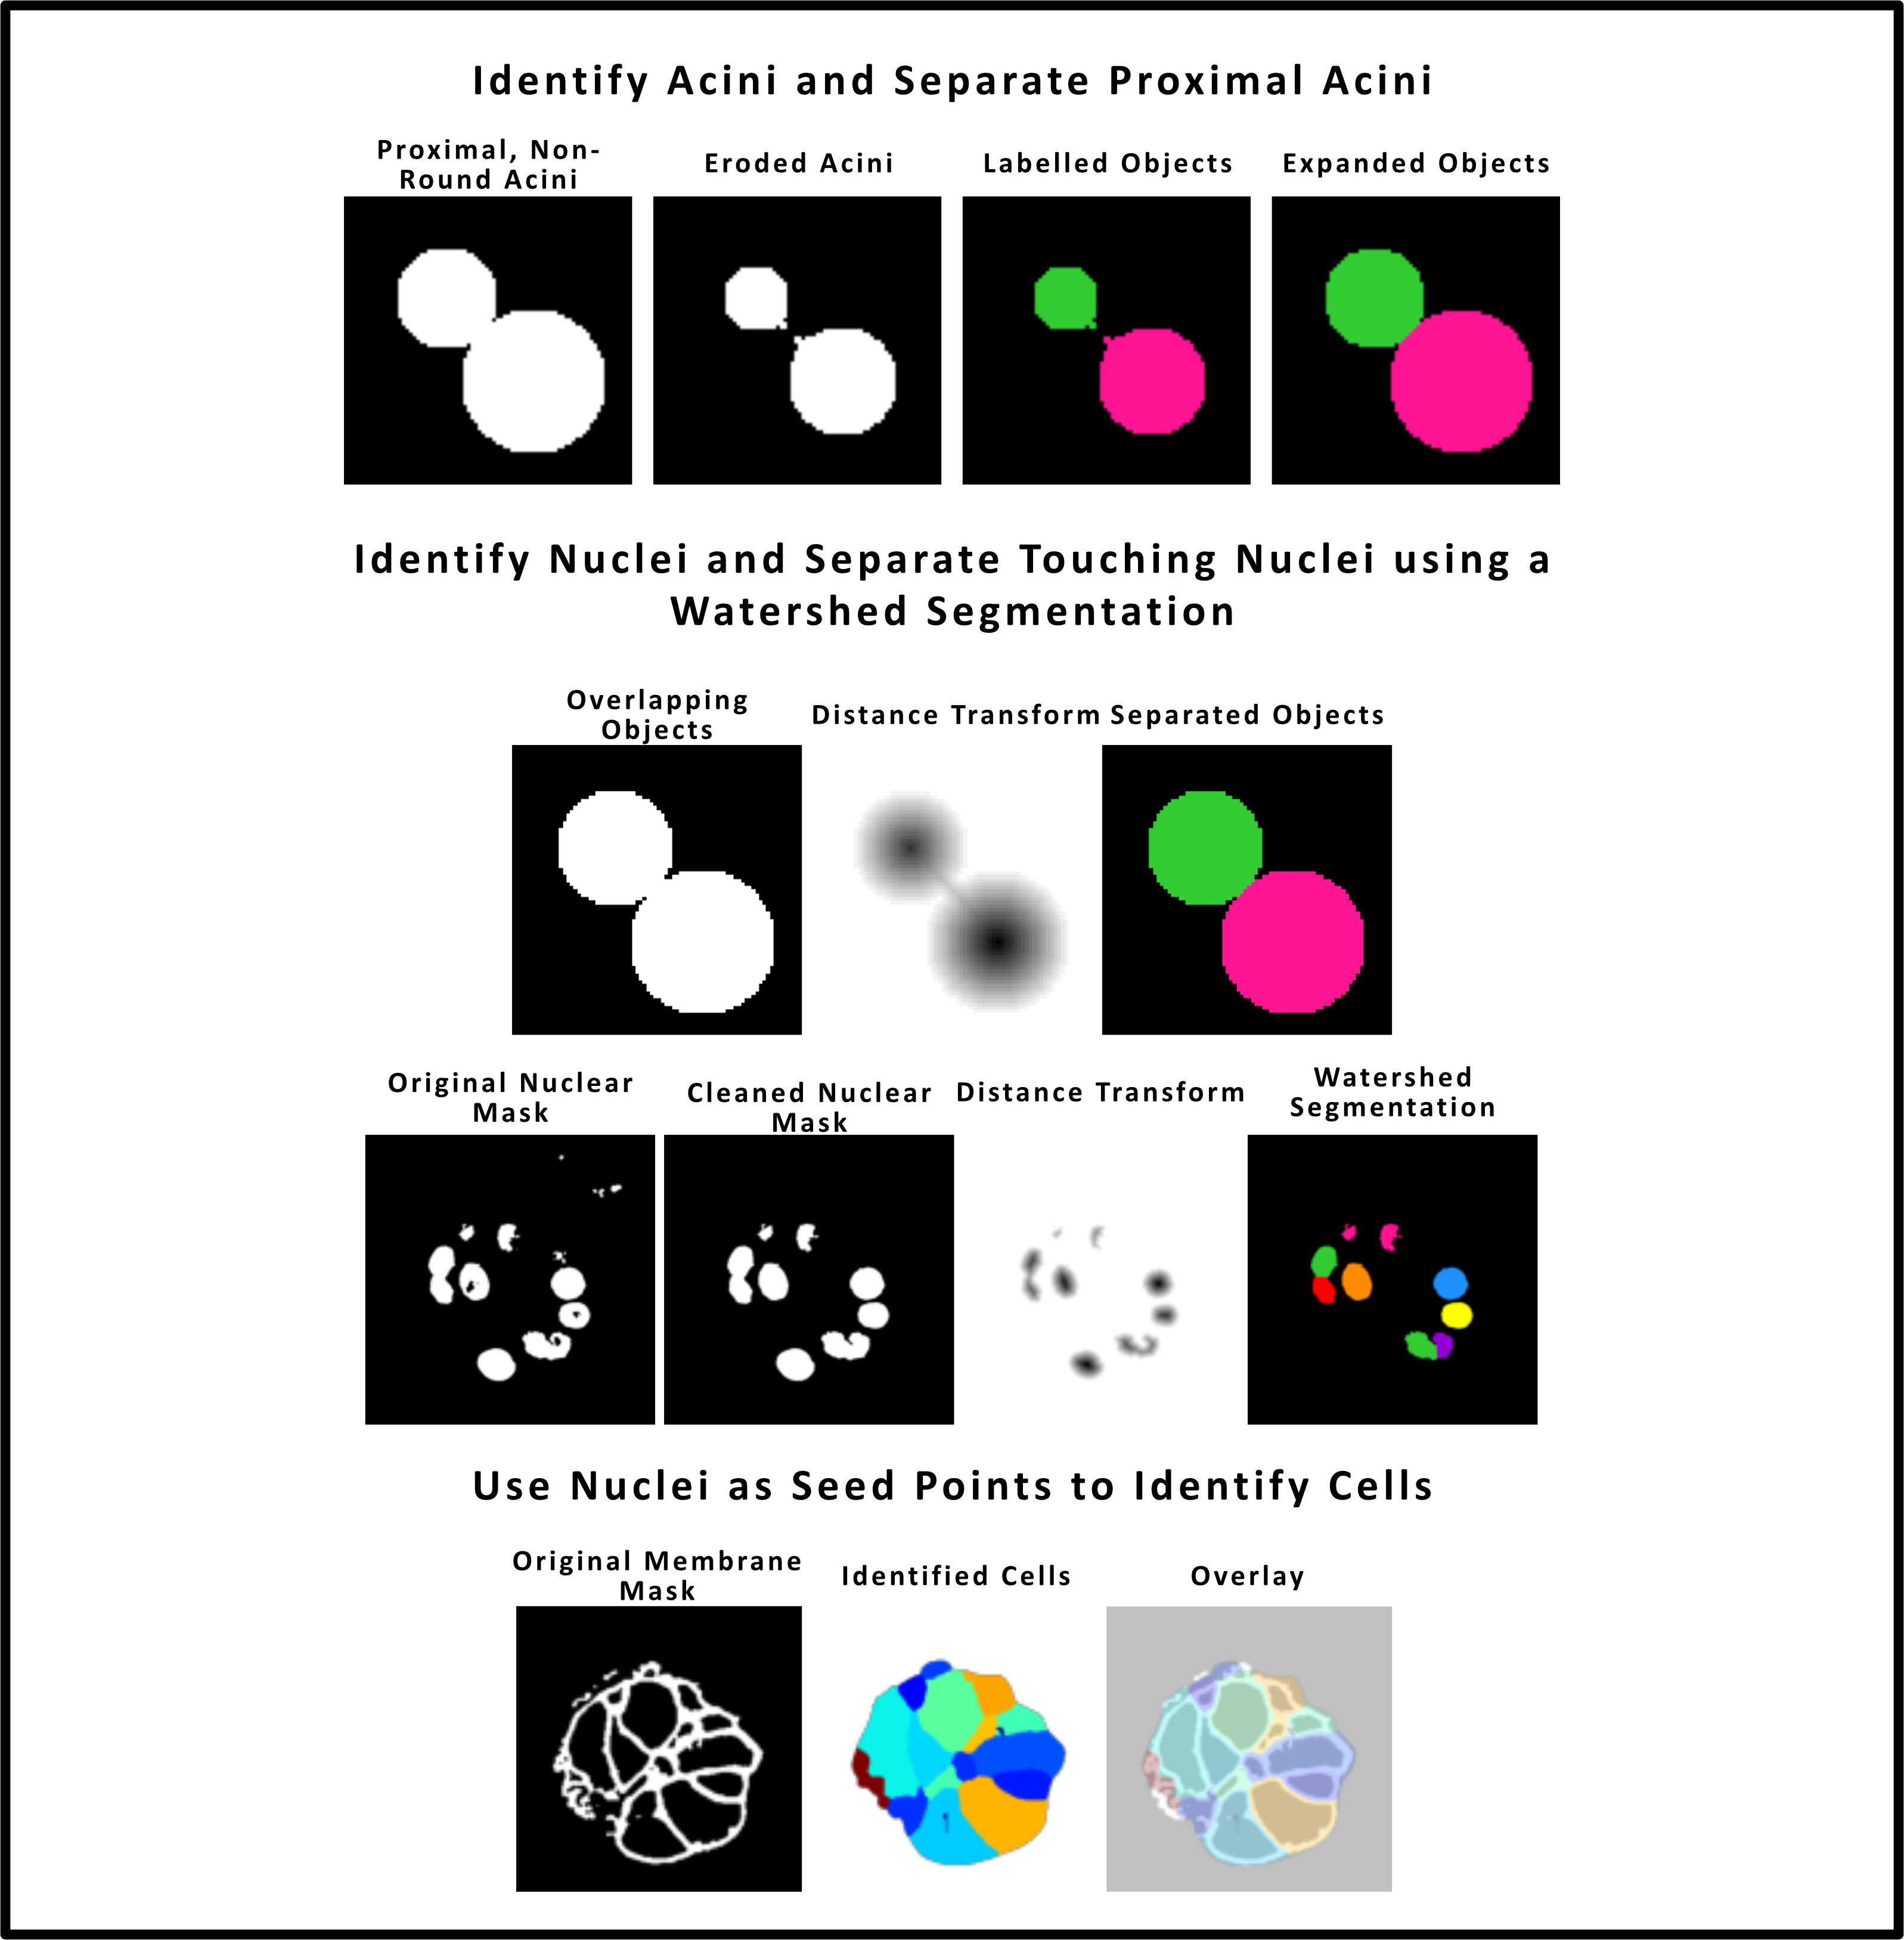

In [1]:
import numpy as np
import pandas as pd
import math
import os
import pathlib
import random

from skimage import exposure, measure, util
from skimage.filters import threshold_otsu, gaussian, threshold_triangle
from skimage.feature import peak_local_max
from skimage.segmentation import expand_labels, clear_border, watershed
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import remove_small_holes, remove_small_objects, ball, erosion, dilation, thin
from skimage.transform import rescale

from scipy import ndimage as ndi

from tifffile import imread
import tifffile
from typing import Tuple, List

import matplotlib.pyplot as plt
from textwrap import wrap

import napari

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm

import tkinter as tk
from tkinter import filedialog

from PIL import ImageColor
import colorsys

# Set custom colour scheme for plots and visualistion
custom_colours = ["dodgerblue", "darkorange", "yellow", "limegreen", "red", "darkviolet", "deeppink" ]

In [2]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    Enables parallel jobs to run and display of a tqdm progress bar.

    Parameters:
    -----------
    tqdm_object : tqdm
        The tqdm progress bar instance to be updated.

    """
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [3]:
def convert(img, target_type_min, target_type_max, target_type):
    """
    Converts an image to a specified data type while scaling its intensity values.

    This function rescales the intensity values of an image from its original range 
    to a new target range specified by `target_type_min` and `target_type_max`, and 
    then converts it to the desired data type.

    This step is required as deconvolved images are not always scaled 0->255! 

    Parameters:
    -----------
    img : numpy.ndarray
        The input image array to be converted.
    target_type_min : int or float
        The minimum value of the target intensity range.
    target_type_max : int or float
        The maximum value of the target intensity range.
    target_type : numpy.dtype
        The desired data type of the output image (e.g., np.uint8, np.float32).

    Returns:
    --------
    new_img : numpy.ndarray
        The rescaled image with values mapped to the new intensity range and converted 
        to the specified data type.

    Notes:
    ------
    - This function performs a linear transformation to scale pixel values.
    - It ensures that the output values are properly mapped between `target_type_min` and 
      `target_type_max`.
    """
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [ ]:
def add_image_details(df, filename, flag):
    """
    Adds experimental details extracted from the filename to a dataframe.

    This function parses the filename to infer experimental details such as 
    well number, imaging day, mechanical stiffness condition, and treatment type.
    The extracted details are appended as new columns to the dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to which image metadata will be added.
    filename : str
        The filename of the image, used to extract experimental details.
    flag : str
        A flag indicating any segmentation issues detected during processing.

    Returns:
    --------
    df : pandas.DataFrame
        The updated dataframe with the following added columns:
        - 'filename': The original filename.
        - 'flag': Segmentation flag indicating potential issues.
        - 'well': The well number (1 or 2) inferred from the filename.
        - 'day': The experimental time point (0, 1, 3, or 7 days).
        - 'condition': The mechanical stiffness condition ('soft', 'stiff', or 'blank').
        - 'treatment': The treatment applied ('blebbistatin', 'ROCKi', 'batimastat', 'ABT737', or 'none').
        - 'image_type': A combined descriptor of the condition and day (e.g., 'soft, d3').
    """
    df["filename"] = filename
    df["flag"] = flag
    if ("well1" in filename):
        df["well"] = 1
    else:
        df["well"] = 2
    # Day #        
    if "d0" in filename:
        df["day"] =  0
    elif "d1" in filename:
        df["day"] =  1
    elif "d3" in filename:
        df["day"] =  3
    else:
        df["day"] =  7
    # Stiffness
    if 'soft' in filename:
        df["condition"] =  'soft'
    elif 'stiff' in filename:
        df["condition"] =  'stiff'
    else:
        df["condition"] =  'blank'
    if "bleb" in filename.lower():
        df["treatment"] = "blebbistatin"
    elif "rock" in filename.lower():
        df["treatment"] = "ROCKi"
    elif ("batimastat" in filename.lower()) or "mmpi" in filename.lower():
        df["treatment"] = "batimastat"
    elif "abt" in filename.lower():
        df["treatment"] = "ABT737"
    else:
        df["treatment"] = "none"
    df['image_type'] = df["condition"].astype(str) + ", d" + df["day"].astype(str)
    return df

In [ ]:
def create_palette(n, base_color_hex):
    """
    Generate a colour palette by adjusting the lightness of a given base colour.

    Parameters:
    ----------
    n : int
        Number of colours to generate in the palette.
    base_color_hex : str
        Base colour in hexadecimal format (e.g., "#FF5733") to derive the palette from.

    Returns:
    -------
    palette : list of tuples
        A list of RGB colour tuples (with values between 0 and 1), representing the palette.
        The colours vary in lightness while maintaining the base hue and saturation.
    
    Notes:
    -----
    - Lightness is varied linearly between 70% and 130% of the original colour's lightness. This can be increased for more contrast.
    """
    r,g,b = ImageColor.getcolor(base_color_hex, "RGB")[0], ImageColor.getcolor(base_color_hex, "RGB")[1], ImageColor.getcolor(base_color_hex, "RGB")[2]
    r=r/255
    g=g/255
    b=b/255
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    lightness_adjustments = np.linspace(0.7, 1.3, n)
    # Create the palette with adjusted lightness while keeping hue and saturation constant
    palette = [colorsys.hls_to_rgb(h, min(max(l * adj, 0), 1), s) for adj in lightness_adjustments]
    return palette

In [ ]:
def custom_napari_palette(n_labels): 
    """
    Generate a custom color map for label visualization in Napari.

    Parameters:
    ----------
    n_labels : int
        Number of distinct labels to assign unique colors to.

    Returns:
    -------
    custom_colormap : dict
        A dictionary mapping label indices to RGBA colors.
        - Label 0 is assigned a transparent black ([0, 0, 0, 0]) for the background.
        - Labels 1 to n_labels are assigned distinct RGB colors (with values in [0, 1])
          generated by varying lightness across 7 base hues:
          limegreen, dodgerblue, red, darkorange, yellow, darkviolet, and deeppink.

    Notes:
    -----
    - Colors are randomly shuffled to visually separate adjacent labels.
    - Colors are returned without alpha (RGBA with A=1.0 assumed by Napari).
    """
    n_col = math.ceil(n_labels/7)
    palette_limegreen = create_palette(n_col,"#32CD32")
    palette_dodgerblue = create_palette(n_col, "#1E90FF")
    palette_red = create_palette(n_col, "#FF0000")
    palette_darkorange = create_palette(n_col, "#FF8C00")  
    palette_yellow = create_palette(n_col, "#FFFF00")  
    palette_darkviolet = create_palette(n_col, "#9400D3")  
    palette_deeppink = create_palette(n_col, "#FF1493")  

    combined_palette = palette_limegreen + palette_dodgerblue +palette_darkorange + palette_red+palette_yellow + palette_darkviolet+ palette_deeppink
    random.shuffle(combined_palette)
    custom_colormap = {0: np.array([0., 0., 0., 0.]),} #black backgroun
    for index, element in enumerate(combined_palette):
        custom_colormap[index+1] = element
    return custom_colormap

In [5]:
def pixel_size(tif_path):
    """
    Extracts the pixel size (spacing) in microns from a TIFF image.

    This function reads TIFF metadata to determine the pixel spacing in the x, y, and z 
    dimensions, returning them as a list.

    Parameters:
    -----------
    tif_path : str
        Path to the TIFF file.

    Returns:
    --------
    original_spacing : list of float
        A list containing the pixel sizes in microns: [x_pixel_size_um, y_pixel_size_um, z_pixel_size_um].

    Notes:
    ------
    - The x and y resolutions are extracted from the TIFF XResolution and YResolution tags.
    - The z-spacing is inferred from the `IJMetadata` tag if available; otherwise, it falls back to 
      the `ImageDescription` tag.
    - Assumes the metadata is formatted in a way compatible with ImageJ or similar software.
    """
    with tifffile.TiffFile(tif_path) as tif:
        tif_tags = {}
        for tag in tif.pages[0].tags.values():
            name, value = tag.name, tag.value
            tif_tags[name] = value

        x_pixel_size_um = 1/((tif_tags["XResolution"])[0]/(tif_tags["XResolution"][1]))
        y_pixel_size_um = 1/((tif_tags["YResolution"])[0]/(tif_tags["YResolution"][1]))
        try:
            z_pixel_size_um = float(str(tif_tags["IJMetadata"]).split("nscales=")[1].split(",")[2].split("\\nunit")[0])
        except:
            z_pixel_size_um = (float(str(tif_tags["ImageDescription"]).split("spacing=")[1].split("loop")[0]))
       
    original_spacing = [x_pixel_size_um,y_pixel_size_um,z_pixel_size_um]
    return original_spacing

In [2]:
def find_neighbours(label_matrix):
    """
    Identify neighboring labeled regions in a 3D label matrix.

    Parameters:
    ----------
    label_matrix : np.ndarray
        A 3D NumPy array where each voxel is assigned an integer label.
        Background is assumed to be labeled as 0, and each object has a unique positive integer label.

    Returns:
    -------
    neighbours_table : pd.DataFrame
        A DataFrame indexed by label ID (excluding background), with the following columns:
        - 'sum' : Number of distinct neighboring labels (i.e., how many different labels touch this one)
        - 'external' : Number of labels (cells) in the image that border background (label 0) 
        - 'internal' : Number of labels (cells) in the image that don't border background
    
    Notes:
    -----
    - A neighbor is defined as any label that touches a voxel on the 6-connected face (not diagonals).
    - Labels without any neighbors are removed (e.g., if they were pruned during preprocessing).
    - The output helps quantify spatial relationships and whether a cell is in contact with the background.
    """
    max = label_matrix.max()
    neighbours = np.zeros((max+1,max+1))
    print(neighbours.shape)
    for i in range(label_matrix.shape[0]):
        for j in range(label_matrix.shape[1]):
            for k in range(label_matrix.shape[2]):
                if i >0:
                    if (label_matrix[i-1, j, k] != label_matrix[i,j,k]):
                        neighbours[label_matrix[i-1, j, k], label_matrix[i,j, k]] = 1
                if i < label_matrix.shape[0]-2:
                    if (label_matrix[i+1, j, k] != label_matrix[i,j, k]): # COULD ALSO INCLUDE DIAGONALS?
                        neighbours[label_matrix[i+1, j, k], label_matrix[i,j, k]]  = 1
                if j > 0 :
                    if (label_matrix[i, j-1, k] != label_matrix[i,j, k]):
                        neighbours[label_matrix[i, j-1, k], label_matrix[i,j, k]]  = 1
                if j < label_matrix.shape[1]-2:
                    if (label_matrix[i, j+1, k] , label_matrix[i,j, k]):
                        neighbours[label_matrix[i, j+1, k], label_matrix[i,j, k]]  = 1
                if k >0:
                    if (label_matrix[i, j, k-1] != label_matrix[i,j, k]):
                        neighbours[label_matrix[i, j, k-1], label_matrix[i,j, k]]  = 1
                if k < label_matrix.shape[2]-2:
                    if (label_matrix[i, j, k+1] != label_matrix[i,j, k]):
                        neighbours[label_matrix[i, j, k+1], label_matrix[i,j, k]]  = 1
                        
    neighbours_table = pd.DataFrame(neighbours)

    neighbours_table = neighbours_table.drop(labels = 0, axis = 1)
    neighbours_table["sum"] = neighbours_table.sum(axis=1)
    neighbours_table = neighbours_table[neighbours_table["sum"] != 0] # sometimes not all labels exist (label n may have been removed because it didn't meet a size threshold), so remove any labels that have no neighbours (i.e. those that aren't really cells)
    neighbours_table["external"] = neighbours_table["sum"][0]
    neighbours_table["internal"] = (len(np.unique(label_matrix))-1) - neighbours_table["sum"][0]

    neighbours_table = neighbours_table[["sum", "external", "internal"]]
    neighbours_table.index.name = "cell_label"

    return neighbours_table


In [ ]:
def find_matching_properties(labelled_nucleus, labelled_cell, new_pixel_size):
    """
    Match each nucleus to its enclosing cell and extract morphological properties for both.

    Parameters:
    ----------
    labelled_nucleus : np.ndarray
        A 3D label image of nuclei, where each nucleus is assigned a unique positive integer label.
    labelled_cell : np.ndarray
        A 3D label image of cells, where each cell is assigned a unique positive integer label.
    new_pixel_size : float
        The physical size of a voxel edge (in microns or other units) for converting voxel counts to volume.

    Returns:
    -------
    matching_nuc_and_cell : pd.DataFrame
        A DataFrame where each row corresponds to a nucleus and includes:
        - `nucleus_label`, `cell_label`: IDs of matched nucleus and enclosing cell
        - `nucleus/cell_volume`: Ratio of nucleus volume to its cell volume
        - `nucleus_volume_um`, `cell_volume_um`: Volumes in physical units
        - `nucleus_roundness`, `cell_roundness`: Approximated as ratio of smallest to largest inertia tensor eigenvalues
        - `sum`, `external`, `internal`: Number of neighboring cells and boundary contacts (from `find_neighbours`)

    Notes:
    -----
    - Matching is done by identifying the cell label at the centroid of each nucleus.
    - Region properties are computed using `skimage.measure.regionprops_table`.
    - Roundness is defined as the ratio of the smallest to the largest principal moment of inertia.
    - Volumes are converted from voxel counts using `new_pixel_size ** 3`.
    - Neighbour information is added via `find_neighbours(labelled_cell)`.
    - Intermediate columns are dropped before returning to reduce clutter.
    """
    matching_nuc_and_cell = []
    for region in (regionprops(labelled_nucleus)):
        x,y,z = int(region.centroid[1]), int(region.centroid[2]), int(region.centroid[0])
        matching_nuc_and_cell.append([region.label, labelled_cell[z,x,y]])
    matching_nuc_and_cell = pd.DataFrame(matching_nuc_and_cell, columns=['nucleus_label', 'cell_label'])
    cell_props = pd.DataFrame(regionprops_table(labelled_cell, properties = ("label", "area", "inertia_tensor_eigvals")))\
        .rename(columns={'label': 'cell_label', 'area': 'cell_volume', "inertia_tensor_eigvals-0":"cell_inertia_tensor_eigvals-0", "inertia_tensor_eigvals-1":"cell_inertia_tensor_eigvals-1", "inertia_tensor_eigvals-2":"cell_inertia_tensor_eigvals-2"})

    nuclear_props = pd.DataFrame(regionprops_table(labelled_nucleus, properties = ("label", "area", "inertia_tensor_eigvals")))\
        .rename(columns={'label': 'nucleus_label', 'area': 'nucleus_volume', "inertia_tensor_eigvals-0":"nucleus_inertia_tensor_eigvals-0", "inertia_tensor_eigvals-1":"nucleus_inertia_tensor_eigvals-1", "inertia_tensor_eigvals-2":"nucleus_inertia_tensor_eigvals-2"})

    matching_nuc_and_cell = matching_nuc_and_cell.merge(cell_props).merge(nuclear_props)

    matching_nuc_and_cell["nucleus/cell_volume"] = matching_nuc_and_cell["nucleus_volume"]/matching_nuc_and_cell["cell_volume"]

    matching_nuc_and_cell["nucleus_volume_um"] = matching_nuc_and_cell["nucleus_volume"] * new_pixel_size**3
    matching_nuc_and_cell["cell_volume_um"] = matching_nuc_and_cell["cell_volume"] * new_pixel_size**3

    matching_nuc_and_cell["cell_roundness"] = matching_nuc_and_cell["cell_inertia_tensor_eigvals-2"]/matching_nuc_and_cell["cell_inertia_tensor_eigvals-0"]
    matching_nuc_and_cell["nucleus_roundness"] = matching_nuc_and_cell["nucleus_inertia_tensor_eigvals-2"]/matching_nuc_and_cell["nucleus_inertia_tensor_eigvals-0"]   

    matching_nuc_and_cell = matching_nuc_and_cell.drop(labels=["cell_volume", "nucleus_volume", "cell_inertia_tensor_eigvals-0", "cell_inertia_tensor_eigvals-1","cell_inertia_tensor_eigvals-2", "nucleus_inertia_tensor_eigvals-0", "nucleus_inertia_tensor_eigvals-1", "nucleus_inertia_tensor_eigvals-2"], axis = 1)
    matching_nuc_and_cell = matching_nuc_and_cell.merge(find_neighbours(labelled_cell).reset_index())

    return matching_nuc_and_cell

In [ ]:
def find_matching_images(membrane_root, nuclear_root , images_root):
    """
    Segmented images from Labkit can be saved with a suffix compared to the original tif e.g. original_filename_nuclear_segmentation.tif, original_filename_membrane_segmentation.tif    
    This code finds and matches membrane and nuclear segmentation images to their corresponding original images based on filenames.

    This function:
    1. Searches for `.tif` images in the provided directories (`membrane_root`, `nuclear_root`, `images_root`).
    2. Sorts the file paths for consistency.
    3. Standardizes filenames by:
       - Converting to lowercase.
       - Removing underscores (`_`).
       - Replacing `+` with `"plus"`.
    4. Extracts relevant parts of filenames for matching.
    5. Identifies the index mapping of original images to their corresponding 
       membrane and nuclear segmentation images.

    Parameters:
    ----------
    membrane_root : str
        Path to the directory containing membrane segmentation images.
    nuclear_root : str
        Path to the directory containing nuclear segmentation images.
    images_root : str
        Path to the directory containing original images.

    Returns:
    -------
    js : list of int
        Indices mapping original images to their corresponding membrane segmentation images.
    ks : list of int
        Indices mapping original images to their corresponding nuclear segmentation images.

    Prints:
    ------
    - The number of `.tif` images found in each directory.

    Notes:
    ------
    - Assumes all original images have corresponding membrane and nuclear segmentations."
    """
    membrane_paths = list(pathlib.Path(membrane_root).glob("**/*.tif"))
    nuclei_paths = list(pathlib.Path(nuclear_root).glob("**/*.tif"))
    image_paths = list(pathlib.Path(images_root).glob("**/*.tif"))
    membrane_paths.sort()
    nuclei_paths.sort()
    image_paths.sort()
    if not (len(membrane_paths) == len(nuclei_paths) == len(image_paths)):
        raise ValueError("File mismatch! There are {} original files, {} membrane segmentations and {} nuclear segmentations".format(len(image_paths), len(membrane_paths), len(nuclei_paths))
        )
    
    filenames_to_match = [os.path.basename(image_paths[i]).lower().replace("_", "").replace("+", "plus").split(".")[0] for i in range(len(image_paths))]
    membrane_filenames_to_match = [("".join(os.path.basename(membrane_paths[i]).lower().replace("+", "plus").split("_")[1:-2])) for i in range(len(image_paths))]
    nuclear_filenames_to_match = [("".join(os.path.basename(nuclei_paths[i]).lower().replace("+", "plus").split("_")[1:-2])) for i in range(len(image_paths))]
    js = []
    ks = []
    for i in range(len(image_paths)):
        j = membrane_filenames_to_match.index(filenames_to_match[i])
        js.append(j)
        k = nuclear_filenames_to_match.index(filenames_to_match[i])
        ks.append(k)
    return js, ks

In [ ]:
def segment_and_quantify(i, js, ks, image_paths, membrane_paths, nuclei_paths, to_plot=True, membrane_channel= 2, nuclear_channel = 0,):
    """
    Segment and quantify 3D microscopy images of acini, nuclei, and membranes.

    Parameters:
    ----------
    i : int
        Index of the current image to process.
    js : list of int
        Index mapping from image_paths to membrane_paths.
    ks : list of int
        Index mapping from image_paths to nuclei_paths.
    image_paths : list of str
        List of file paths for the raw multichannel image stacks.
    membrane_paths : list of str
        List of file paths for membrane binary masks (aligned to raw images).
    nuclei_paths : list of str
        List of file paths for nuclear binary masks (aligned to raw images).
    to_plot : bool, default=True
        Whether to generate and save output diagnostic plots.
    membrane_channel : int, default=2
        Index of the membrane (e.g. CAAX) channel in the raw image stack.
    nuclear_channel : int, default=0
        Index of the nuclear (e.g. DAPI) channel in the raw image stack.

    Returns:
    -------
    segmented_nuclear_labels : np.ndarray
        Labelled 3D nuclear segmentation image.
    segmented_membrane : np.ndarray
        Labelled 3D membrane segmentation image (unexpanded).
    segmented_membrane_expanded : np.ndarray
        Expanded membrane segmentation image, constrained to the acinus.
    new_pixel_size : float
        Isotropic pixel size used for volume calculations (in microns).
    filename : str
        Cleaned filename of the processed image.
    matching : pd.DataFrame
        Table of matched nucleus-cell pairs with calculated shape metrics.
    rescaled_acinus_image : np.ndarray
        Intensity projection image used for initial acinus identification.
    rescaled_nuclear_mask : np.ndarray
        Nuclear mask after acinus masking and rescaling.
    cleaned_membrane_mask : np.ndarray
        Membrane mask after masking and smoothing.
    filtered_labelled_acinus : np.ndarray
        Final binary mask identifying the primary acinus.

    Notes:
    -----
    - The function automatically identifies the main acinus by filtering based on size and sphericity.
    - Nuclei are segmented using distance transform and watershed, with size filtering to remove small objects.
    - Cell boundaries are inferred from membrane signal, again using watershed seeded by nuclear centroids.
    - Resulting labels are associated via centroid matching, and geometric descriptors (volume, roundness) are computed.
    - Optional plotting provides a 4-panel view (nuclei/membranes raw vs. segmented) at the middle z-plane.
    """
    filename = os.path.basename(image_paths[i]).replace("_", "").lower().replace("+", "plus")
    try:
        ##############RESCALE IMAGES
        flag = "None"
        nuclear_mask = imread(nuclei_paths[ks[i]])
        membrane_mask = imread(membrane_paths[js[i]])
        caax_image = convert(imread(image_paths[i])[:,membrane_channel,:,:], 0,255, np.uint8)
        nuclear_image = convert(imread(image_paths[i])[:,nuclear_channel,:,:], 0,255, np.uint8)

        original_spacing = pixel_size(nuclei_paths[i])
        new_pixel_size = 4 * original_spacing[0]
        scale_change = original_spacing[2] / original_spacing[0]

        rescaled_nuclear_mask = rescale(scale = (0.25*scale_change, 0.25, 0.25), image = nuclear_mask, anti_aliasing= False)
        rescaled_membrane_mask = rescale(scale = (0.25*scale_change, 0.25, 0.25), image = membrane_mask, anti_aliasing= False)
        rescaled_acinus_image = rescale(scale = (0.25*scale_change, 0.25, 0.25), image = caax_image + nuclear_image, anti_aliasing= False)

        #######IDENTIFY ACINAR VOLUME######################################################################################
        clipped_acinus = rescaled_acinus_image.clip(min =np.quantile(rescaled_acinus_image, 0.1), max = np.quantile(rescaled_acinus_image, 0.85))
        smoothed_acinus = gaussian(clipped_acinus, sigma = 4)
        thresh = threshold_otsu(smoothed_acinus)
        binary_acinus = smoothed_acinus > thresh
        binary_acinus = remove_small_holes(binary_acinus, area_threshold = 100000)
        binary_acinus = remove_small_objects(binary_acinus, min_size = 10000)
        labelled_acinus = label(binary_acinus)
        table = regionprops_table(labelled_acinus, properties=('label', "area"),) #only keep largest acinus
        condition = (table['area'] >= (table["area"]).max())
        input_labels = table['label']
        output_labels = input_labels * condition
        filtered_labelled_acinus = util.map_array(labelled_acinus, input_labels, output_labels)
        table = regionprops_table(filtered_labelled_acinus, properties=('label', 'inertia_tensor_eigvals'),) #test sphericity of largest identified acinus
        condition = table['inertia_tensor_eigvals-2']/table['inertia_tensor_eigvals-0'] >= (0.55)
        #######SEPARATE PROXIMAL ACINI IF NECESSARY########################################################################
        if condition == False:
            flag = "multiple_acini_split"
            smoothed_acinus = gaussian(clipped_acinus, sigma = 1)
            thresh = threshold_otsu(smoothed_acinus)
            binary_acinus = smoothed_acinus > thresh
            binary_acinus = remove_small_holes(binary_acinus, area_threshold = 100000)
            binary_acinus = remove_small_objects(binary_acinus, min_size = 10000)
            binary_acinus = erosion(binary_acinus, ball(8))
            labelled_acinus = label(binary_acinus)
            table = regionprops_table(labelled_acinus, properties=('label', "area"),)
            condition = (table['area'] >= (table["area"]).max())
            input_labels = table['label']
            output_labels = input_labels * condition
            filtered_labelled_acinus = util.map_array(labelled_acinus, input_labels, output_labels)
            filtered_labelled_acinus = expand_labels(filtered_labelled_acinus, distance=8)
        cleaned_acinus_mask = filtered_labelled_acinus * (filtered_labelled_acinus>0)
    #######DISCARD ANY SIGNAL OUTSIDE THE IDENTIFIED ACINUS############################################################
        rescaled_membrane_mask = rescaled_membrane_mask * cleaned_acinus_mask
        rescaled_nuclear_mask = rescaled_nuclear_mask * cleaned_acinus_mask
    #######PROCESS THE NUCLEAR BINARY MASK##############################################################################
        cleaned_nuclear_mask = gaussian(rescaled_nuclear_mask, 1)
        thresh = threshold_otsu(cleaned_nuclear_mask)
        cleaned_nuclear_mask = cleaned_nuclear_mask > thresh
        cleaned_nuclear_mask = remove_small_holes(cleaned_nuclear_mask, area_threshold = 1000)
        #####################SEPARATE TOUCHING NUCLEI####################
        distances = ndi.distance_transform_edt(erosion(cleaned_nuclear_mask, ball(3)))
        coordinates = peak_local_max(distances, min_distance = int(4/new_pixel_size)) ####seed points at least 4um apart
        marker_locations = coordinates.data
        markers = np.zeros(cleaned_nuclear_mask.shape, dtype=np.uint32)
        marker_indices = tuple(np.round(marker_locations).astype(int).T)
        markers[marker_indices] = np.arange(len(marker_locations)) + 1
        markers_big = dilation(markers, ball(2))
        segmented = watershed(-distances, markers_big, mask=cleaned_nuclear_mask)
        segmented = clear_border(segmented)
        ## Filter out small nuclei
        table = regionprops_table(segmented, properties=('label', 'area'),)
        volume_threshold = (4/3)*np.pi * (2/new_pixel_size)**3     # radius 2um nucleus
        condition = (table['area'] >= volume_threshold)
        input_labels = table['label']
        output_labels = input_labels * condition
        segmented_nuclear_labels = util.map_array(segmented, input_labels, output_labels)
    #######PROCESS THE MEMBRANE BINARY MASK############################################################################
        cleaned_membrane_mask = gaussian(rescaled_membrane_mask, sigma = 1) # Apply some smoothing to fill any gaps
        thresh = threshold_otsu(cleaned_membrane_mask)
        cleaned_membrane_mask = cleaned_membrane_mask > thresh
        # cleaned_thinned_membrane_mask = thin(cleaned_membrane_mask[0,:,:], max_num_iter=4)
        # for i in range(1, rescaled_membrane_mask.shape[0]):
        #     thinned = thin(rescaled_membrane_mask[i,:,:], max_num_iter=4)
        #     cleaned_thinned_membrane_mask = np.dstack((cleaned_thinned_membrane_mask, thinned))
        # cleaned_membrane_mask = np.rollaxis(cleaned_thinned_membrane_mask, 2,0)
        # cleaned_membrane_mask = remove_small_objects(cleaned_membrane_mask, min_size = 40)

        #############WATERSHED OF MEMBRANE BASED ON NUCLEI POSITIONS
        zvalues = regionprops_table(segmented_nuclear_labels, properties =( "label", "centroid"))["centroid-0"]
        xvalues = regionprops_table(segmented_nuclear_labels, properties =( "label", "centroid"))["centroid-1"]
        yvalues = regionprops_table(segmented_nuclear_labels, properties =( "label", "centroid"))["centroid-2"]
        coordinates = np.stack((zvalues, xvalues, yvalues), axis=0).T.astype(int)
        distances = ndi.distance_transform_edt(util.invert(cleaned_membrane_mask))
        marker_locations = coordinates.data
        markers = np.zeros(cleaned_membrane_mask.shape, dtype=np.uint32)
        marker_indices = tuple(np.round(marker_locations).astype(int).T)
        markers[marker_indices] = np.arange(len(marker_locations)) + 1
        markers_big = dilation(markers, ball(2))
        segmented = watershed(-distances, markers_big, mask=util.invert(cleaned_membrane_mask))
        segmented_membrane = clear_border(segmented)
        segmented_membrane_expanded = expand_labels(segmented_membrane, distance = 12)
        segmented_membrane_expanded = segmented_membrane_expanded * cleaned_acinus_mask
        
        matching = find_matching_properties(segmented_nuclear_labels, segmented_membrane_expanded, new_pixel_size)
        matching = add_image_details(matching, filename, flag)
        if original_spacing ==[1,1,1]:
            matching["flag"] = "wrong metadata"
    # #######PLOT OUTPUTS IF NECESSARY###################################################################################
        if to_plot ==True:
            z = int(cleaned_nuclear_mask.shape[0]/2)

            gridspec = dict(hspace=0.0, wspace=0.01, width_ratios=[1,1,1,1,])
            fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(13,6), gridspec_kw = gridspec)

            ax[0].imshow(cleaned_nuclear_mask[z,:,:], cmap="gray", interpolation = "none")
            ax[1].imshow(segmented_nuclear_labels[z,:,:],  cmap="jet", interpolation = "none")
            ax[2].imshow(cleaned_membrane_mask[z,:,:], cmap="gray", interpolation = "none")
            ax[3].imshow(segmented_membrane_expanded[z,:,:],  cmap="jet", interpolation = "none")
            cols = ["Mask", "Identified", "Mask", "Identified"]
            for i in range(4):
                ax[-i].axis("off")
                ax[-i].set_title(cols[-i])
            title = filename
            plt.savefig("segmented_membrane_{}_z={}.pdf".format(title, z), transparent=True, bbox_inches="tight")
            return segmented_nuclear_labels, segmented_membrane, segmented_membrane_expanded, new_pixel_size, filename, matching, rescaled_acinus_image, rescaled_nuclear_mask, cleaned_membrane_mask, filtered_labelled_acinus
        else:
            return matching
    except:
        matching = pd.DataFrame()
        matching["flag"] = "IMAGE FAILED"
        matching["filename"] = filename

<!-- # Analyse -->

<!-- # Single Run -->

## Single Run

In [20]:
main_root = "C:\\Users\\itayl\\The University of Manchester Dropbox\\Isobel Taylor-Hearn\\Bel\\nuclear_seg"
membrane_root = main_root + "\\membrane"
nuclear_root = main_root + "\\nuclear"
images_root = main_root + "\\original"
js, ks = find_matching_images(membrane_root, nuclear_root , images_root)
image_paths = list(pathlib.Path(images_root).rglob("*.{}".format("tif")))
membrane_paths = list(pathlib.Path(membrane_root).rglob("*.{}".format("tif")))
nuclear_paths = list(pathlib.Path(nuclear_root).rglob("*.{}".format("tif")))


(38, 38)


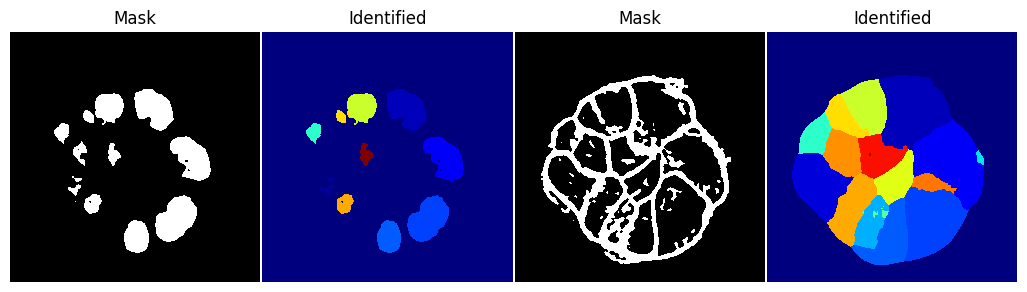

In [ ]:
i=0
segmented_nuclear_labels, segmented_membrane, segmented_membrane_expanded, new_pixel_size, filename, matching, rescaled_acinus_image, rescaled_nuclear_mask, cleaned_membrane_mask, filtered_labelled_acinus = segment_and_quantify(i, js, ks, image_paths, membrane_paths, nuclear_paths, to_plot=True, membrane_channel=2)

In [ ]:
custom_colormap = custom_napari_palette(segmented_nuclear_labels.max())
viewer = napari.Viewer()
viewer.add_labels(segmented_membrane_expanded, colormap = custom_colormap)

<!-- # Full Run -->

## Full Folder Analysis with Parallelisation

In [ ]:
main_root  = "path\\to\\folder"
file_identifier = "eg_protein"
membrane_root = main_root + "\\segmentations\\combined_binary_membrane"
nuclear_root = main_root + "\\segmentations\\combined_binary_nuclear"
images_root = main_root + "\\final_tifs"

membrane_paths = list(pathlib.Path(membrane_root).glob("**/*.tif"))
nuclei_paths = list(pathlib.Path(nuclear_root).glob("**/*.tif"))
image_paths = list(pathlib.Path(images_root).glob("**/*.tif"))
membrane_paths.sort()
nuclei_paths.sort()
image_paths.sort()

print(len(membrane_paths), len(nuclei_paths))
if len(membrane_paths) != len(nuclei_paths):
    print("CHECK DIRECTORY!")
    print(len(membrane_paths), len(nuclei_paths))

#####FOR EVERYTHING BUT LAMPAX
filenames_to_match = [os.path.basename(image_paths[i]).lower().replace("_", "").split(".")[0] for i in range(len(image_paths))]
membrane_filenames_to_match = [("".join(os.path.basename(membrane_paths[i]).lower().split("_")[1:-2])) for i in range(len(image_paths))]
nuclear_filenames_to_match = [("".join(os.path.basename(nuclei_paths[i]).lower().split("_")[1:-2])) for i in range(len(image_paths))]
js = []
ks = []
for i in range(len(image_paths)):
    j = membrane_filenames_to_match.index(filenames_to_match[i])
    js.append(j)
    k = nuclear_filenames_to_match.index(filenames_to_match[i])
    ks.append(k)

with tqdm_joblib(tqdm(desc="Image Analysis", total=len(nuclei_paths))) as progress_bar:
    morphological_params = Parallel(n_jobs=3)(delayed(segment_and_quantify)(i, js, ks, image_paths, membrane_paths, nuclei_paths, to_plot=False) for i in range(len(nuclei_paths)))
total = pd.concat(morphological_params).reset_index()
total.to_csv("{}_shape_size_nuclei_cells.csv".format(file_identifier))


140 140


Image Analysis: 100%|██████████| 140/140 [1:19:27<00:00, 34.05s/it]


140 140


Image Analysis: 100%|██████████| 140/140 [1:28:36<00:00, 37.98s/it]


60 60


Image Analysis: 100%|██████████| 60/60 [36:15<00:00, 36.25s/it] 


(108, 108)


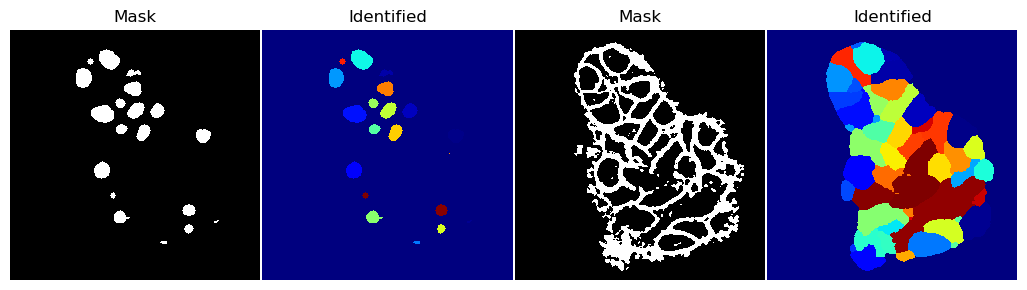

In [ ]:
# i = 0
# segmented_nuclear_labels, segmented_membrane, segmented_membrane_expanded, new_pixel_size, filename, matching, rescaled_acinus_image, rescaled_nuclear_mask, clean_thin_membrane = segment_and_quantify(i, js, ks, image_paths, membrane_paths, nuclei_paths, to_plot=True)